Explain predictions using captum

In [73]:
%load_ext autoreload
%autoreload 2

In [109]:
from dataset import FakeDatasetIsPlanar, split_dataset
from visualization import visualize
from model import GCN, SAGE, ConvGNN, CustomSAGE
from training.train_eval import TrainEval
from training.train_eval_graphless import TrainEvalGraphless

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import OneHotDegree, Constant
from torch_geometric.datasets import FakeDataset
from torch_geometric.nn import GCNConv
from torch_geometric.explain import Explainer, GNNExplainer
from torch import nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
import torch
import random
import numpy as np
import random
from collections import defaultdict

# One hot 8 dataset and SAGE-3 model

In [2]:
NUM_GRAPHS = 1000000
NUM_EPOCH = 100

In [3]:
%%time

torch.manual_seed(1234)
np.random.seed(3241)
random.seed(4534)

avg_degree = 4
max_degree = avg_degree * 5 // 2

one_hot_degree = OneHotDegree(max_degree, cat=False)

ds_onehot_8 = FakeDatasetIsPlanar(num_graphs=NUM_GRAPHS, avg_num_nodes=8, avg_degree=avg_degree,
                               transform=one_hot_degree)
print(f"Planar graphs: {int(ds_onehot_8.y.sum())}")
ds_onehot_8

Planar graphs: 216652
CPU times: user 4min 30s, sys: 4.73 s, total: 4min 35s
Wall time: 4min 46s


FakeDatasetIsPlanar(1000000)

In [4]:
ds_onehot_5_sparse = FakeDatasetIsPlanar(num_graphs=NUM_GRAPHS//10, avg_num_nodes=5, avg_degree=1,
                                         transform=one_hot_degree)
print(f"Planar graphs: {int(ds_onehot_5_sparse.y.sum())}")
ds_onehot_5_sparse

Planar graphs: 100000


FakeDatasetIsPlanar(100000)

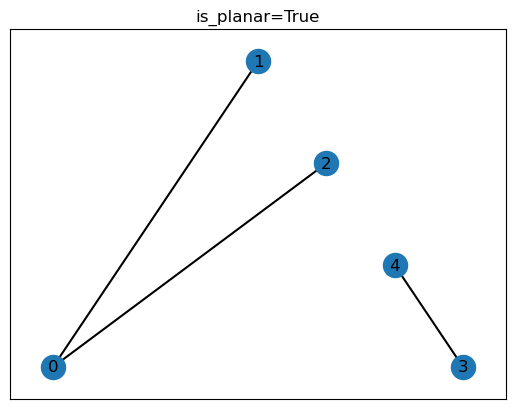

In [5]:
visualize(ds_onehot_5_sparse[4])

In [7]:
ds_onehot_mix = ds_onehot_8 + ds_onehot_5_sparse

In [14]:
onehot_8_train_loader, onehot_8_test_loader = split_dataset(ds_onehot_8, batch_size=64, shuffle=False)

Number of training graphs: 800000
Number of test graphs: 200000


In [11]:
device = torch.device('cpu') #'mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='cpu')

ConvGNN(
  (conv1): GraphConv(11, 11)
  (conv2): GraphConv(11, 11)
  (conv3): GraphConv(11, 11)
  (lin): Linear(in_features=11, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.9751, precision=0.9300, recall=0.9570, size=800000.0000, f1=0.9433, Test: accuracy=0.9749, precision=0.9302, recall=0.9568, size=200000.0000, f1=0.9433
Epoch:  02, Train: accuracy=0.9799, precision=0.9652, recall=0.9410, size=800000.0000, f1=0.9530, Test: accuracy=0.9794, precision=0.9647, recall=0.9396, size=200000.0000, f1=0.9520
Epoch:  03, Train: accuracy=0.9793, precision=0.9617, recall=0.9420, size=800000.0000, f1=0.9517, Test: accuracy=0.9792, precision=0.9621, recall=0.9415, size=200000.0000, f1=0.9517
Epoch:  04, Train: accuracy=0.9811, precision=0.9674, recall=0.9444, size=800000.0000, f1=0.9558, Test: accuracy=0.9807, precision=0.9670, recall=0.9436, size=200000.0000, f1=0.9552
Epoch:  05, Train: accuracy=0.9827, precision=0.9682, recall=0.9510, size=800000.0000, f1=0.9596, Test: accuracy=0.

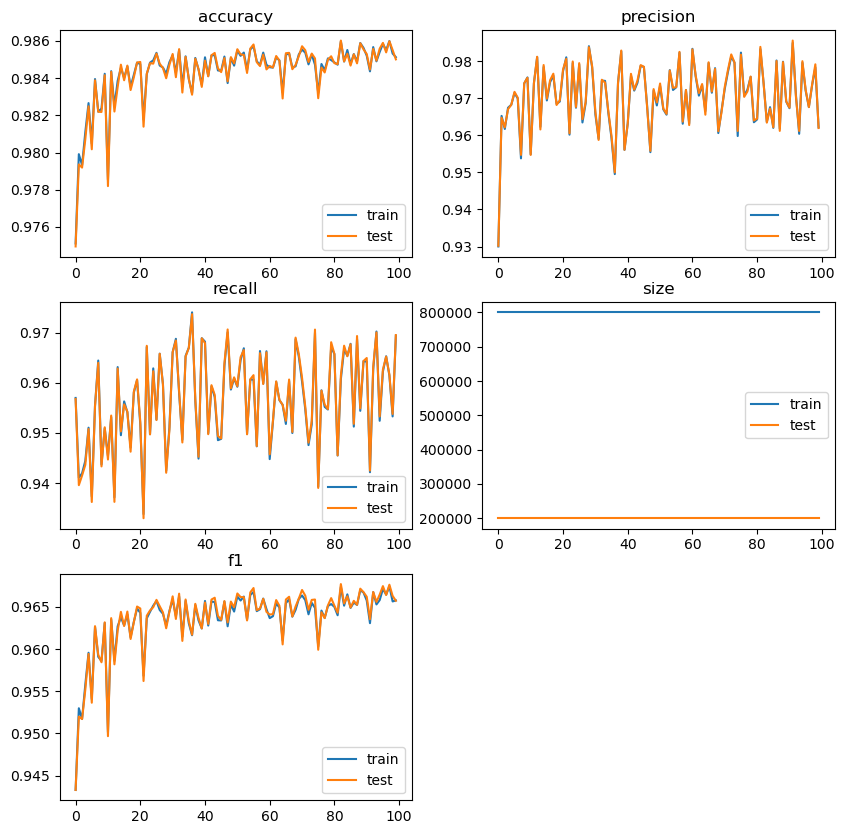

| Test F1 | Test F1 10 | Test Accuracy | Train F1 | Train Accuracy |
|---|---|---|---|---|
| 0.9657238236144988 | 0.9662065398488133 | 0.98501 | 0.9657619592155525 | 0.98512875 |
CPU times: user 2h 17min 48s, sys: 7min, total: 2h 24min 48s
Wall time: 3h 30min 8s


In [47]:
%%time

conv_model = ConvGNN(hidden_channels=11, num_node_features=ds_onehot_8.num_node_features,
                     num_classes=2)
conv_model = conv_model.to(device)

print(conv_model)

te = TrainEval(conv_model, device)
te.main(NUM_EPOCH, onehot_8_train_loader, onehot_8_test_loader)

In [50]:
torch.save(conv_model.state_dict(), "./conv_8_one_hot_100epoch.pickle")

In [9]:
!ls

Check_dataset.ipynb            __pycache__
D2L.ipynb                      conv_8_one_hot_100epoch.pickle
Explain_GNN.ipynb              dataset
Is_Planar.ipynb                model
Is_Planar_15_nodes.ipynb       training
PyG_dataset_transforms.ipynb   utils.py
Temp_metrics.ipynb             visualization


# Explain with GNNExplainer

https://arxiv.org/pdf/1903.03894.pdf

Using example: https://github.com/pyg-team/pytorch_geometric/blob/master/examples/explain/gnn_explainer.py

In [12]:
# load the model
conv_model = ConvGNN(hidden_channels=11, num_node_features=ds_onehot_8.num_node_features,
                     num_classes=2)
conv_model = conv_model.to(device)

conv_model.load_state_dict(torch.load("./conv_8_one_hot_100epoch.pickle"))

print(conv_model)

ConvGNN(
  (conv1): GraphConv(11, 11)
  (conv2): GraphConv(11, 11)
  (conv3): GraphConv(11, 11)
  (lin): Linear(in_features=11, out_features=2, bias=True)
)


In [129]:
explainer = Explainer(
    model=conv_model,
    algorithm=GNNExplainer(epochs=100),
    explanation_type='model',
    node_mask_type=None,
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='graph',
        return_type='raw',
    ),
)
explainer

In [61]:
_, onehot_8_test_loader_single = split_dataset(ds_onehot_8, batch_size=1, shuffle=False)

Number of training graphs: 800000
Number of test graphs: 200000


tensor([0])
edge mask: tensor([0.2440, 0.2350, 0.2408, 0.8398, 0.2156, 0.8487, 0.8330, 0.2496, 0.2063,
        0.1864, 0.8631, 0.1418, 0.1643, 0.1965, 0.8275, 0.2343, 0.8399, 0.1801,
        0.1671, 0.8871, 0.8321, 0.1921, 0.2298, 0.1643, 0.8714, 0.8343, 0.8351,
        0.1862, 0.8504, 0.2466, 0.8310, 0.2329, 0.2146, 0.1498, 0.8921, 0.8479,
        0.2198, 0.2402, 0.2023, 0.1510, 0.8352, 0.1820, 0.8389, 0.2472, 0.1436,
        0.2146, 0.1539, 0.2391])
edge adjm: tensor([0.0500, 0.0500, 0.0500, 0.8398, 0.0500, 0.8487, 0.0500, 0.0500, 0.0500,
        0.0500, 0.8631, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.8399, 0.0500,
        0.0500, 0.8871, 0.0500, 0.0500, 0.0500, 0.0500, 0.8714, 0.0500, 0.0500,
        0.0500, 0.8504, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.8921, 0.8479,
        0.0500, 0.0500, 0.0500, 0.0500, 0.8352, 0.0500, 0.8389, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500])


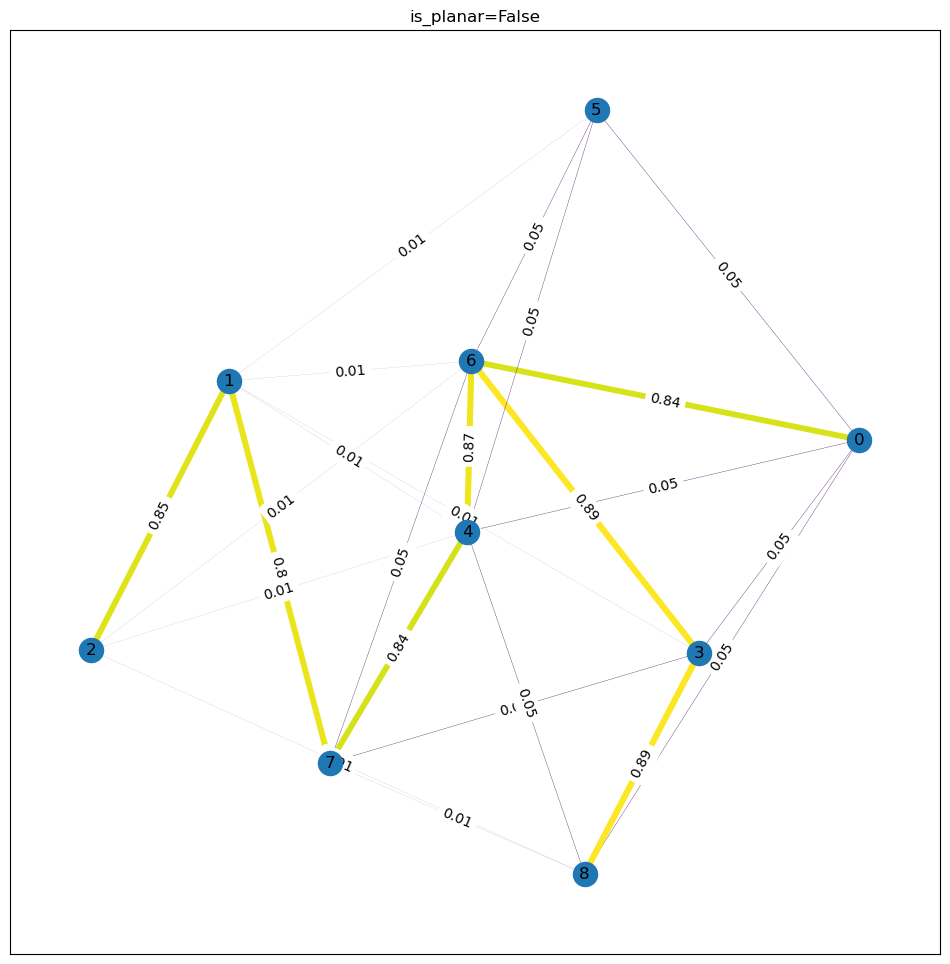

tensor([1])
edge mask: tensor([0.5387, 0.8197, 0.6744, 0.7000, 0.9048, 0.6638, 0.8350, 0.8386, 0.5521,
        0.7005, 0.9368, 0.2953, 0.4402, 0.3302, 0.8587, 0.4183])
edge adjm: tensor([0.0500, 0.8197, 0.6744, 0.7000, 0.9048, 0.6638, 0.8350, 0.8386, 0.5521,
        0.7005, 0.9368, 0.0500, 0.0500, 0.0500, 0.8587, 0.0500])


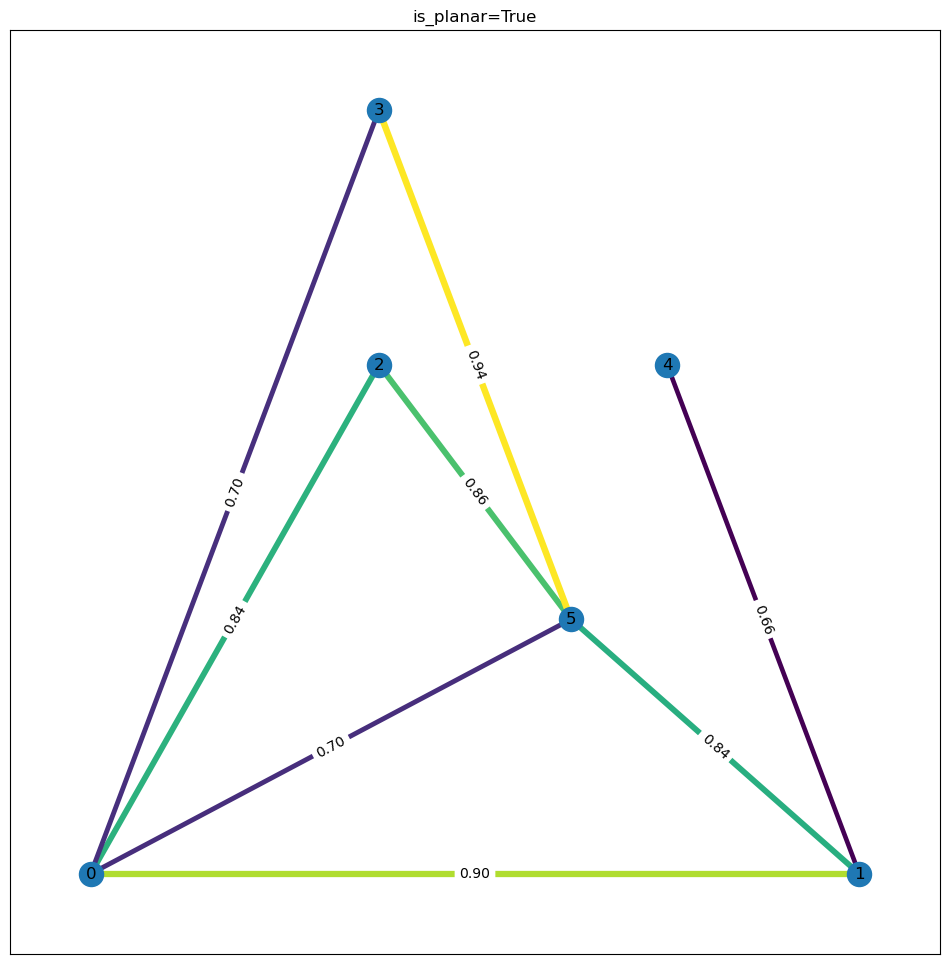

tensor([0])
edge mask: tensor([0.2226, 0.2227, 0.2378, 0.2331, 0.1774, 0.2309, 0.2273, 0.8289, 0.8482,
        0.2064, 0.2045, 0.2354, 0.2091, 0.2346, 0.8360, 0.8390, 0.2520, 0.1962,
        0.1936, 0.8400, 0.2331, 0.2481, 0.1756, 0.2178, 0.8292, 0.8709, 0.8512,
        0.8422, 0.2282, 0.8276, 0.8335, 0.2480, 0.2386, 0.8572, 0.8442, 0.8576,
        0.2141, 0.2399, 0.2415, 0.8451, 0.8559, 0.2054, 0.8273, 0.2452, 0.2022,
        0.8327, 0.8294, 0.2033, 0.1234, 0.1773])
edge adjm: tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.8482,
        0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.8390, 0.0500, 0.0500,
        0.0500, 0.8400, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.8709, 0.8512,
        0.8422, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.8572, 0.8442, 0.8576,
        0.0500, 0.0500, 0.0500, 0.8451, 0.8559, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.0500, 0.0500])


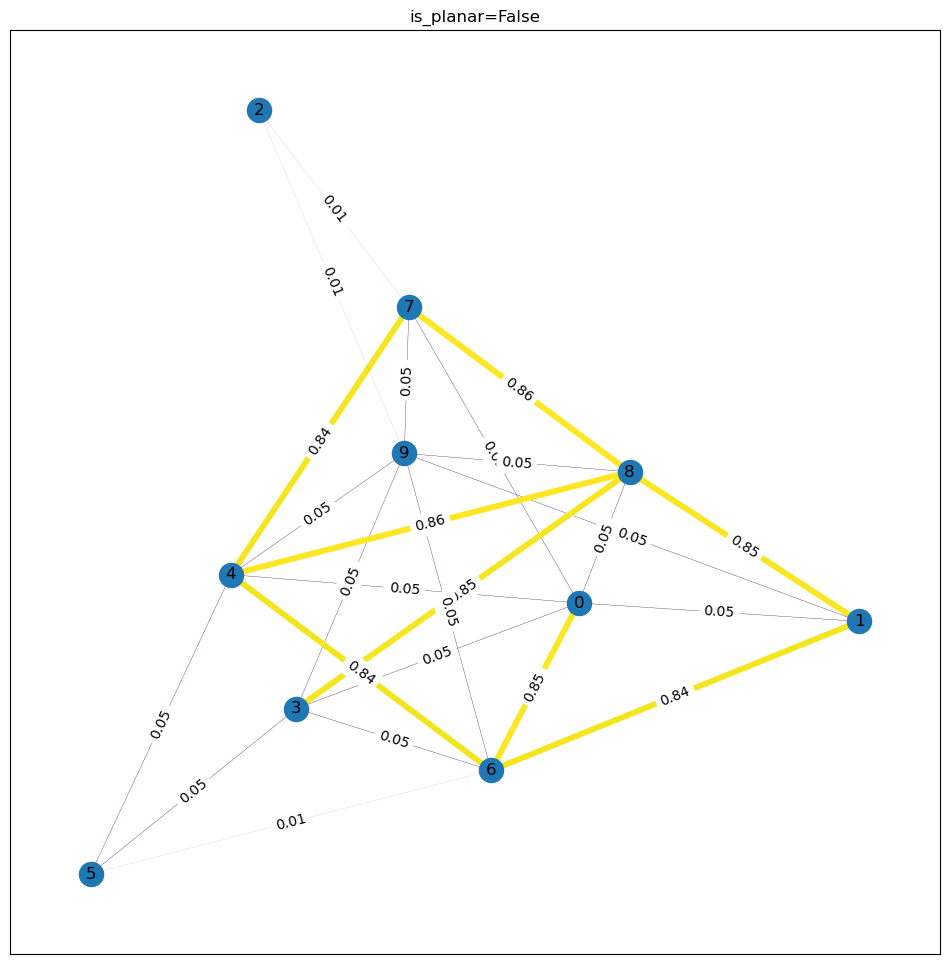

tensor([0])
edge mask: tensor([0.8627, 0.2006, 0.8523, 0.2057, 0.2037, 0.2216, 0.8343, 0.1320, 0.2011,
        0.2282, 0.1465, 0.2416, 0.8380, 0.8349, 0.2156, 0.2277, 0.1798, 0.2218,
        0.1249, 0.8505, 0.8264, 0.2027, 0.2230, 0.8516, 0.1464, 0.2386, 0.1943,
        0.8390, 0.1709, 0.1956, 0.9312, 0.2310, 0.1783, 0.2115, 0.8224, 0.8321,
        0.2330, 0.8313, 0.2255, 0.2269])
edge adjm: tensor([0.8627, 0.0500, 0.8523, 0.0500, 0.0500, 0.0500, 0.8343, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.8380, 0.8349, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.8505, 0.0500, 0.0500, 0.0500, 0.8516, 0.0500, 0.0500, 0.0500,
        0.8390, 0.0500, 0.0500, 0.9312, 0.0500, 0.0500, 0.0500, 0.0500, 0.8321,
        0.0500, 0.8313, 0.0500, 0.0500])


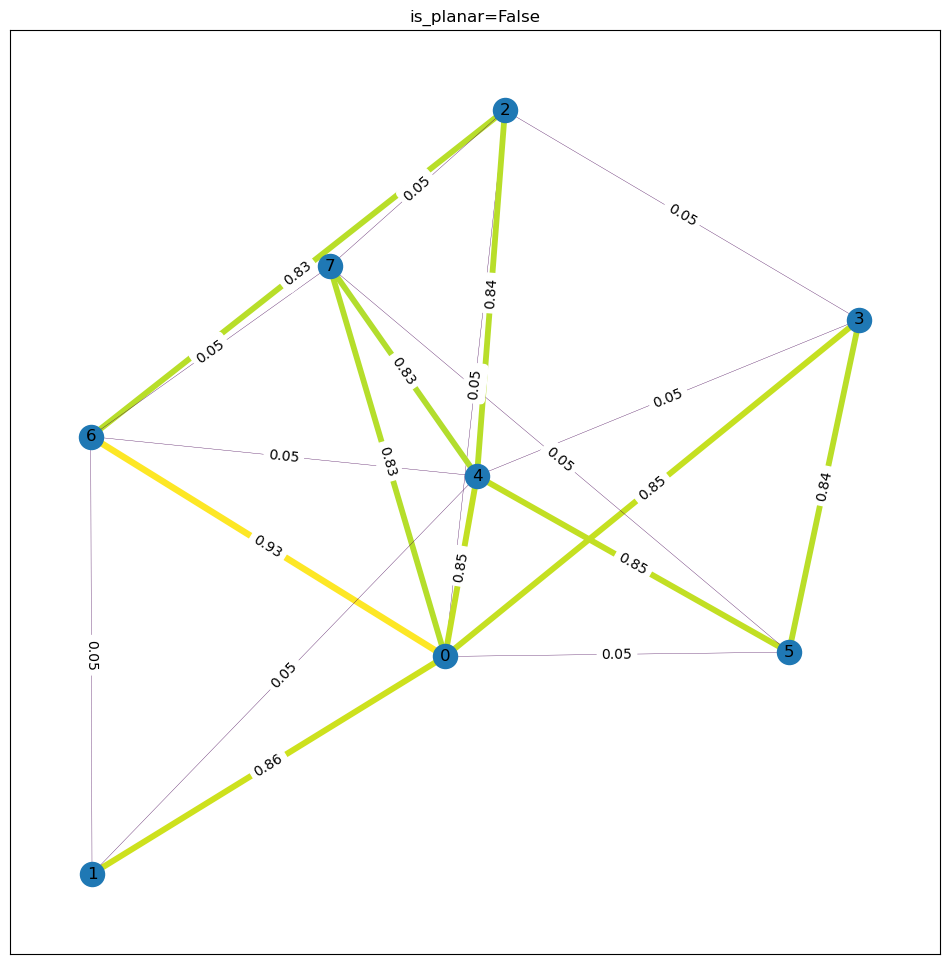

tensor([0])
edge mask: tensor([0.8373, 0.2433, 0.1943, 0.8772, 0.1767, 0.2591, 0.8268, 0.2356, 0.2468,
        0.8591, 0.2557, 0.1791, 0.8202, 0.8050, 0.8456, 0.2380, 0.8154, 0.2291,
        0.1270, 0.8268, 0.1994, 0.2416, 0.8268, 0.1935, 0.2293, 0.8238, 0.1509,
        0.2690, 0.1951, 0.2452, 0.8614, 0.2309, 0.2133, 0.2256])
edge adjm: tensor([0.8373, 0.0500, 0.0500, 0.8772, 0.0500, 0.0500, 0.8268, 0.0500, 0.0500,
        0.8591, 0.0500, 0.0500, 0.8202, 0.0500, 0.8456, 0.0500, 0.8154, 0.0500,
        0.0500, 0.8268, 0.0500, 0.0500, 0.8268, 0.0500, 0.0500, 0.8238, 0.0500,
        0.0500, 0.0500, 0.0500, 0.8614, 0.0500, 0.0500, 0.0500])


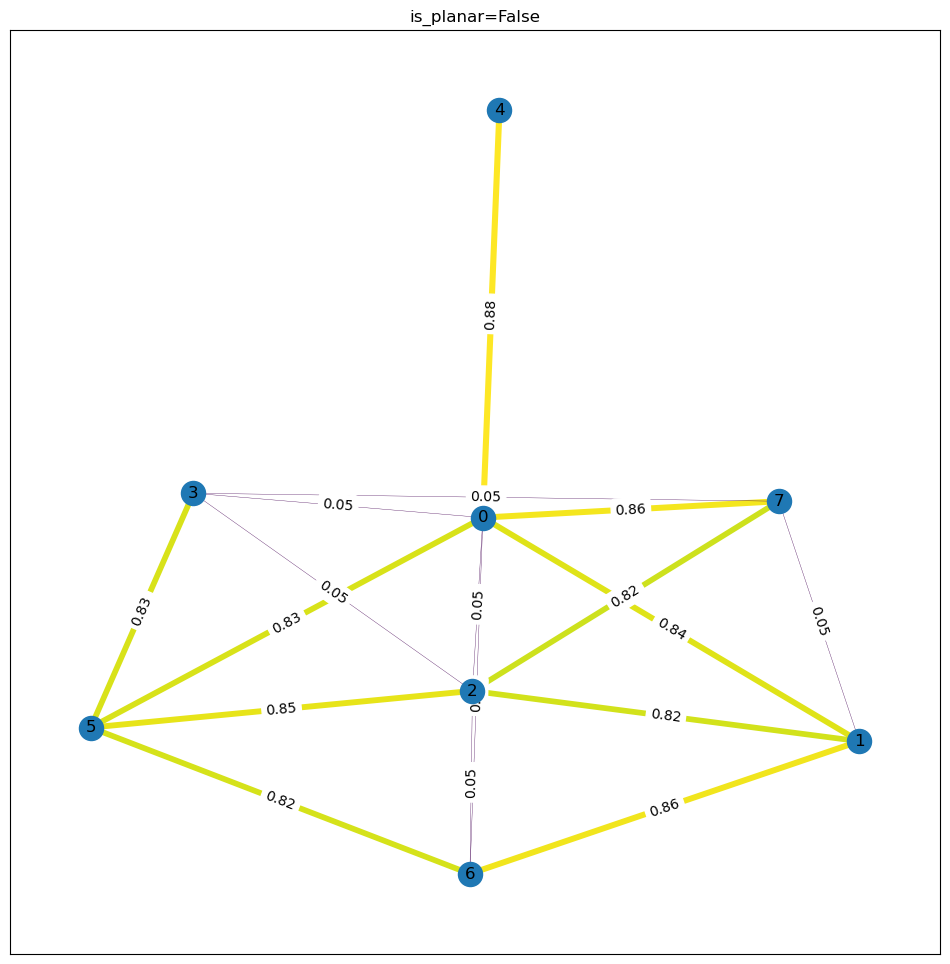

tensor([1])
edge mask: tensor([0.7164, 0.7372, 0.7240, 0.7014, 0.6734, 0.6120, 0.6784, 0.3613, 0.4375,
        0.4946, 0.6136, 0.5103, 0.8986, 0.6246, 0.4643, 0.7575, 0.3341, 0.6912])
edge adjm: tensor([0.7164, 0.7372, 0.7240, 0.7014, 0.6734, 0.0500, 0.6784, 0.0500, 0.0500,
        0.0500, 0.6136, 0.0500, 0.8986, 0.6246, 0.0500, 0.7575, 0.0500, 0.6912])


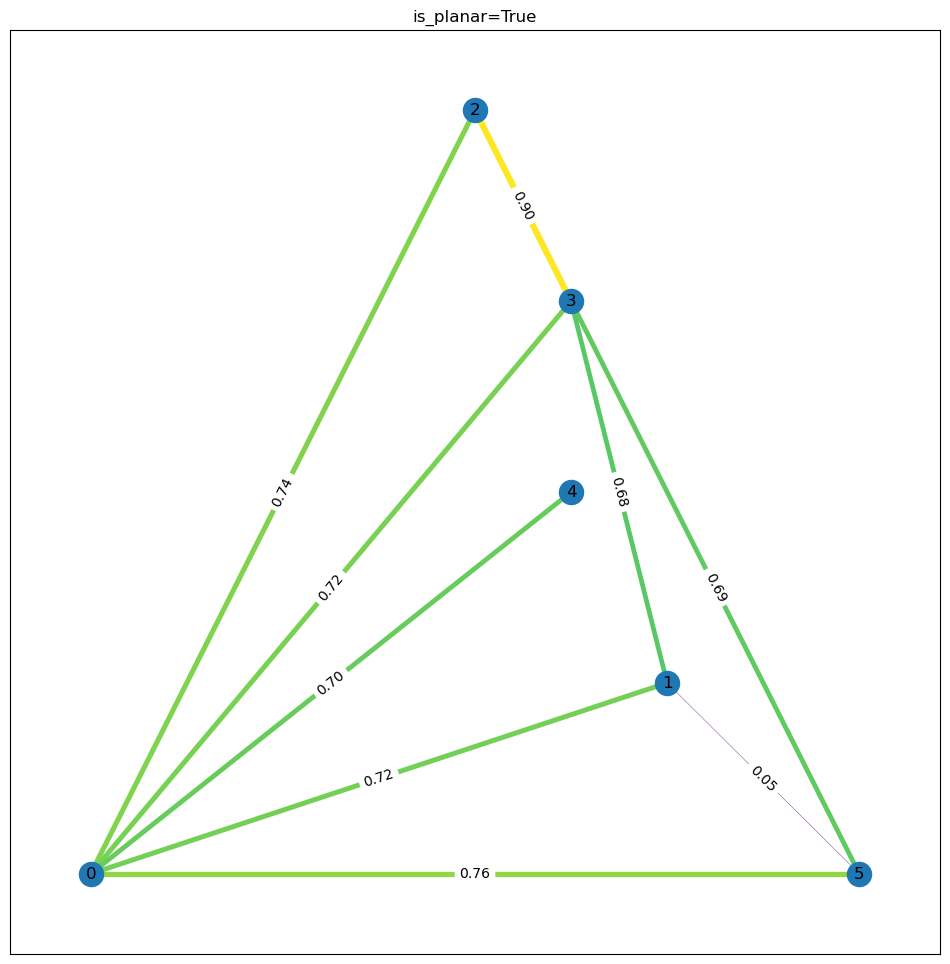

tensor([0])
edge mask: tensor([0.2338, 0.1615, 0.2338, 0.8192, 0.2142, 0.1993, 0.2065, 0.9073, 0.8255,
        0.8596, 0.8805, 0.2116, 0.8243, 0.1681, 0.8446, 0.1973, 0.1609, 0.1820,
        0.2281, 0.2102, 0.8635, 0.8214, 0.2186, 0.1857, 0.8364, 0.1943, 0.2265,
        0.2246, 0.8601, 0.8522, 0.2120, 0.8390, 0.8955, 0.2198, 0.2324, 0.1966])
edge adjm: tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.9073, 0.8255,
        0.8596, 0.8805, 0.0500, 0.0500, 0.0500, 0.8446, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500, 0.8635, 0.0500, 0.0500, 0.0500, 0.8364, 0.0500, 0.0500,
        0.0500, 0.8601, 0.8522, 0.0500, 0.8390, 0.8955, 0.0500, 0.0500, 0.0500])


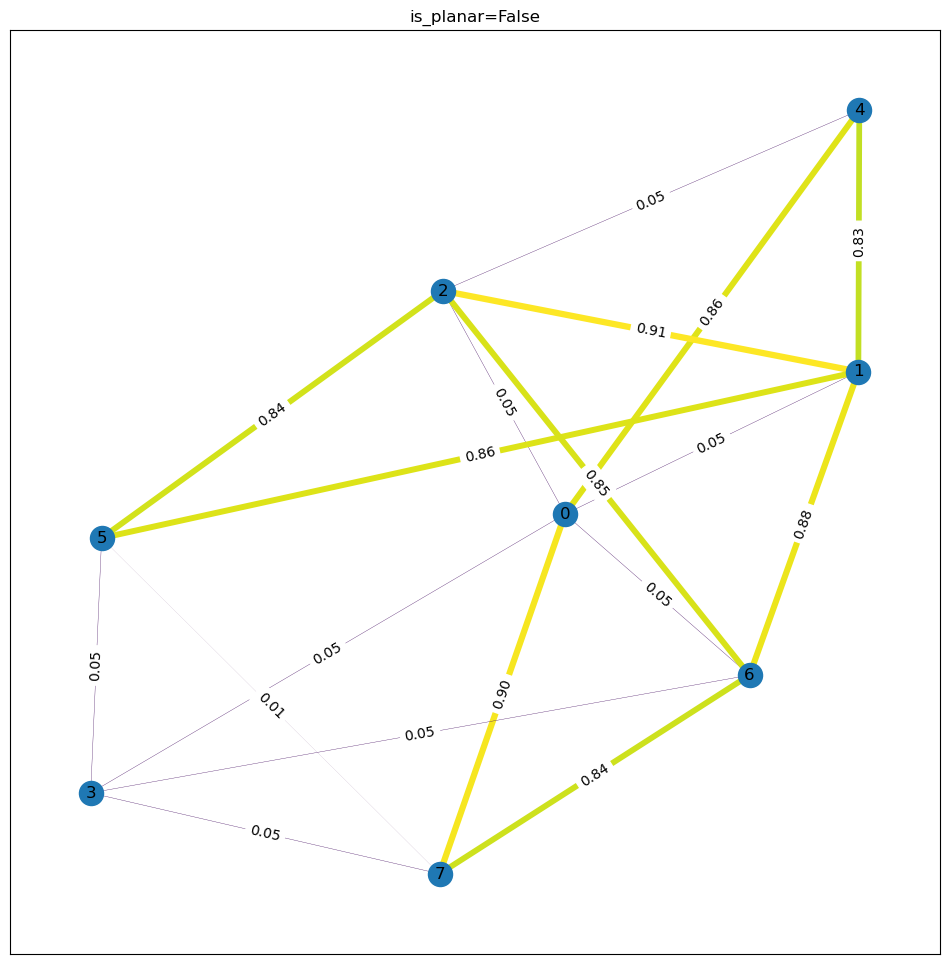

tensor([1])
edge mask: tensor([0.5978, 0.5691, 0.7556, 0.6858, 0.5919, 0.4637, 0.8142, 0.4430, 0.7038,
        0.5463, 0.5659, 0.5111, 0.5458, 0.4381, 0.5289, 0.5434, 0.6401, 0.3035,
        0.1610, 0.4832, 0.6190, 0.3231, 0.5561, 0.7347])
edge adjm: tensor([0.5978, 0.5691, 0.7556, 0.6858, 0.5919, 0.0500, 0.8142, 0.0500, 0.7038,
        0.0500, 0.5659, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.6401, 0.0500,
        0.0500, 0.0500, 0.6190, 0.0500, 0.0500, 0.7347])


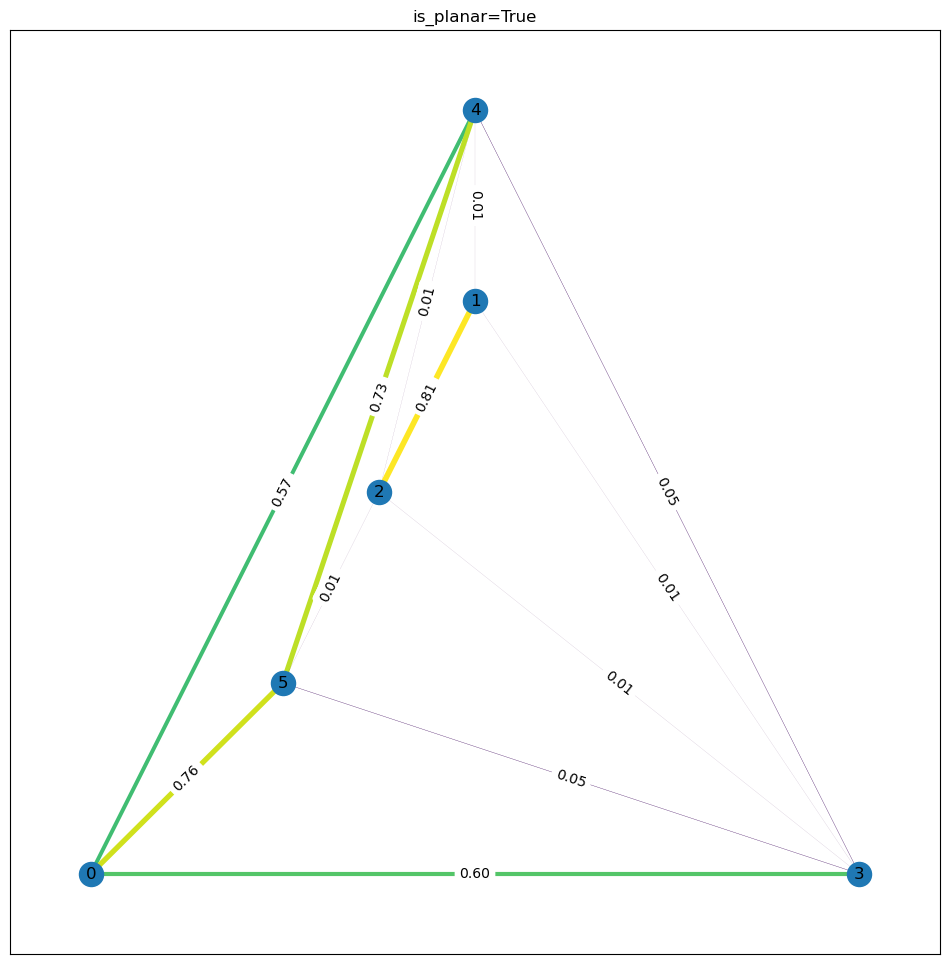

tensor([0])
edge mask: tensor([0.8646, 0.8392, 0.8123, 0.8215, 0.2368, 0.2152, 0.1663, 0.2457, 0.8223,
        0.2141, 0.8236, 0.8539, 0.2199, 0.1849, 0.1672, 0.1424, 0.2081, 0.1641,
        0.8194, 0.2326, 0.1397, 0.2057, 0.2072, 0.2183, 0.1224, 0.1709, 0.2300,
        0.1782, 0.2071, 0.8332, 0.8332, 0.2042, 0.2214, 0.8357, 0.8674, 0.8306,
        0.8233, 0.8260, 0.1437, 0.8303])
edge adjm: tensor([0.8646, 0.8392, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.8236, 0.8539, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500, 0.8332, 0.8332, 0.0500, 0.0500, 0.8357, 0.8674, 0.8306,
        0.0500, 0.8260, 0.0500, 0.8303])


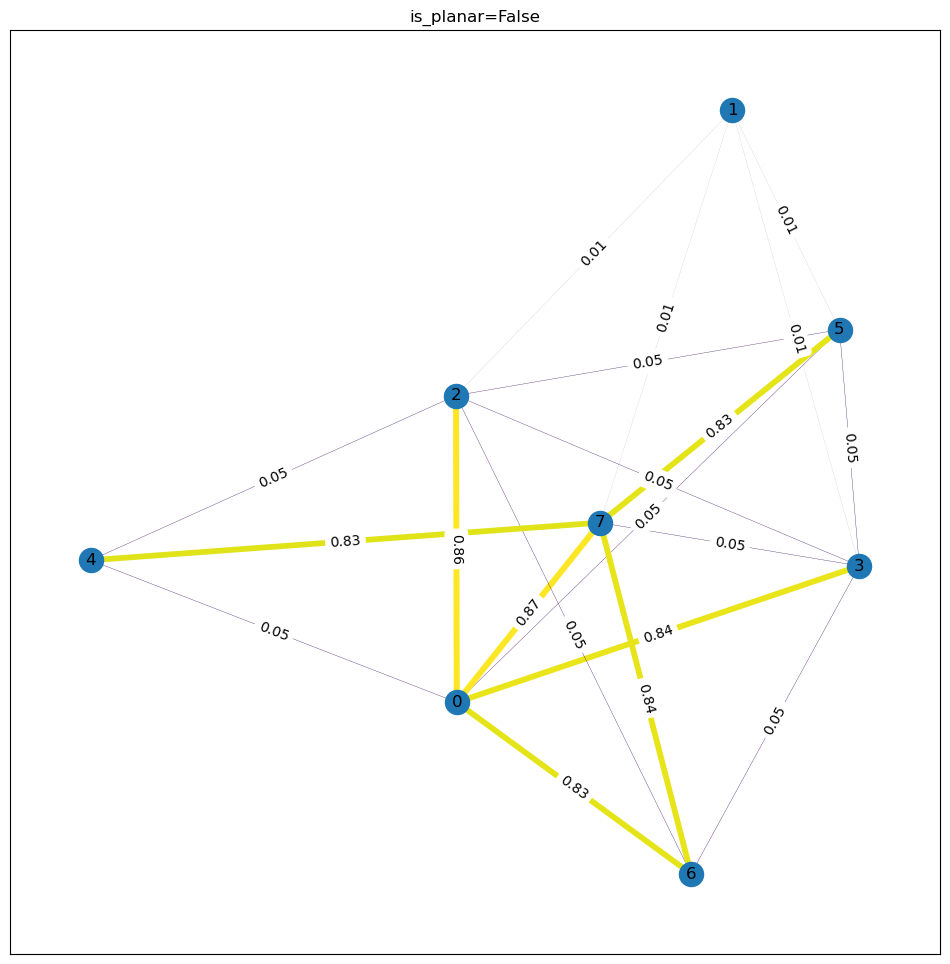

tensor([0])
edge mask: tensor([0.1790, 0.8712, 0.2306, 0.8135, 0.2240, 0.1525, 0.8396, 0.2134, 0.2348,
        0.8356, 0.2351, 0.2046, 0.1770, 0.9109, 0.1899, 0.1760, 0.1573, 0.8220,
        0.8212, 0.2263, 0.8141, 0.2119, 0.0835, 0.8345, 0.9089, 0.1383, 0.2266,
        0.8752, 0.8293, 0.8358, 0.1946, 0.8649, 0.2386, 0.2030, 0.8701, 0.8288,
        0.1692, 0.8199])
edge adjm: tensor([0.0500, 0.8712, 0.0500, 0.0500, 0.0500, 0.0500, 0.8396, 0.0500, 0.0500,
        0.8356, 0.0500, 0.0500, 0.0500, 0.9109, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.8345, 0.9089, 0.0500, 0.0500,
        0.8752, 0.8293, 0.8358, 0.0500, 0.8649, 0.0500, 0.0500, 0.8701, 0.0500,
        0.0500, 0.0500])


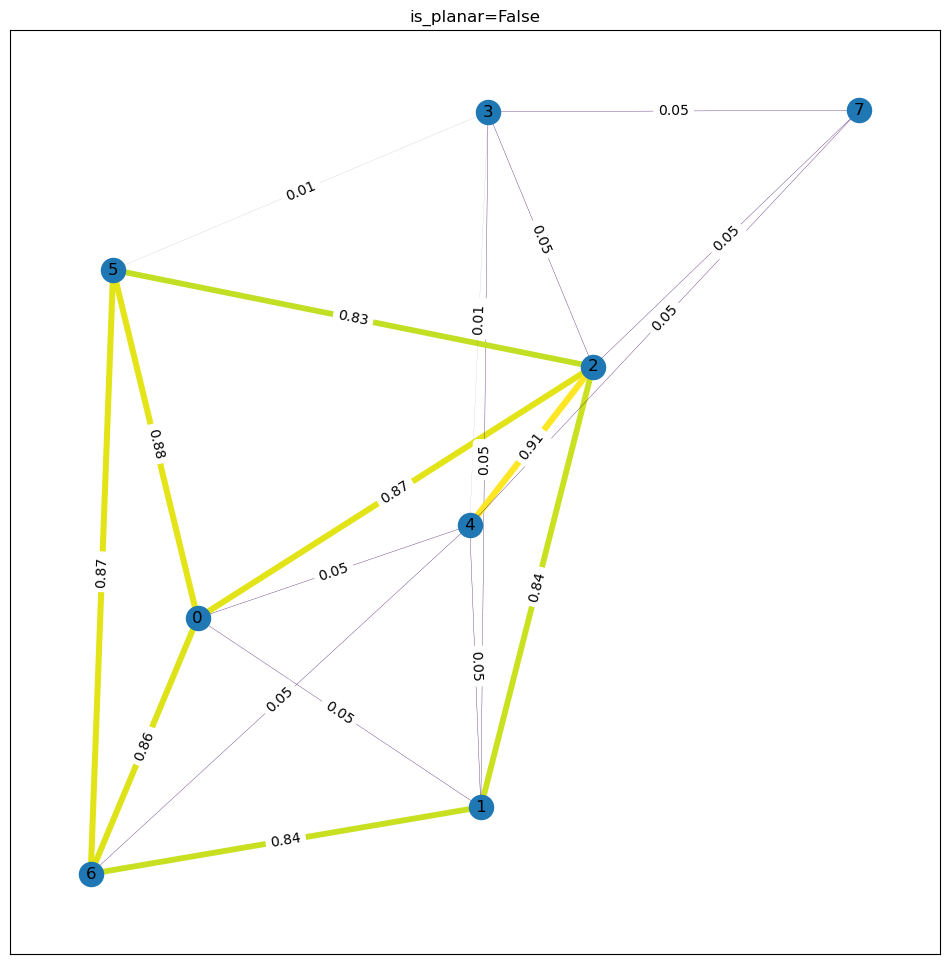

tensor([0])
edge mask: tensor([0.2276, 0.2112, 0.8329, 0.0693, 0.1453, 0.1339, 0.2068, 0.8308, 0.8305,
        0.8445, 0.2251, 0.8415, 0.2191, 0.1451, 0.8392, 0.8272, 0.1926, 0.2366,
        0.2128, 0.2378, 0.2295, 0.8359, 0.2257, 0.1580, 0.2267, 0.8241, 0.2014,
        0.8313, 0.1630, 0.8907, 0.2214, 0.1786, 0.1829, 0.1411, 0.1860, 0.2160,
        0.2247, 0.2232])
edge adjm: tensor([0.0500, 0.0500, 0.8329, 0.0500, 0.0500, 0.0500, 0.0500, 0.8308, 0.8305,
        0.8445, 0.0500, 0.8415, 0.0500, 0.0500, 0.8392, 0.8272, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.8359, 0.0500, 0.0500, 0.0500, 0.8241, 0.0500,
        0.8313, 0.0500, 0.8907, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500])


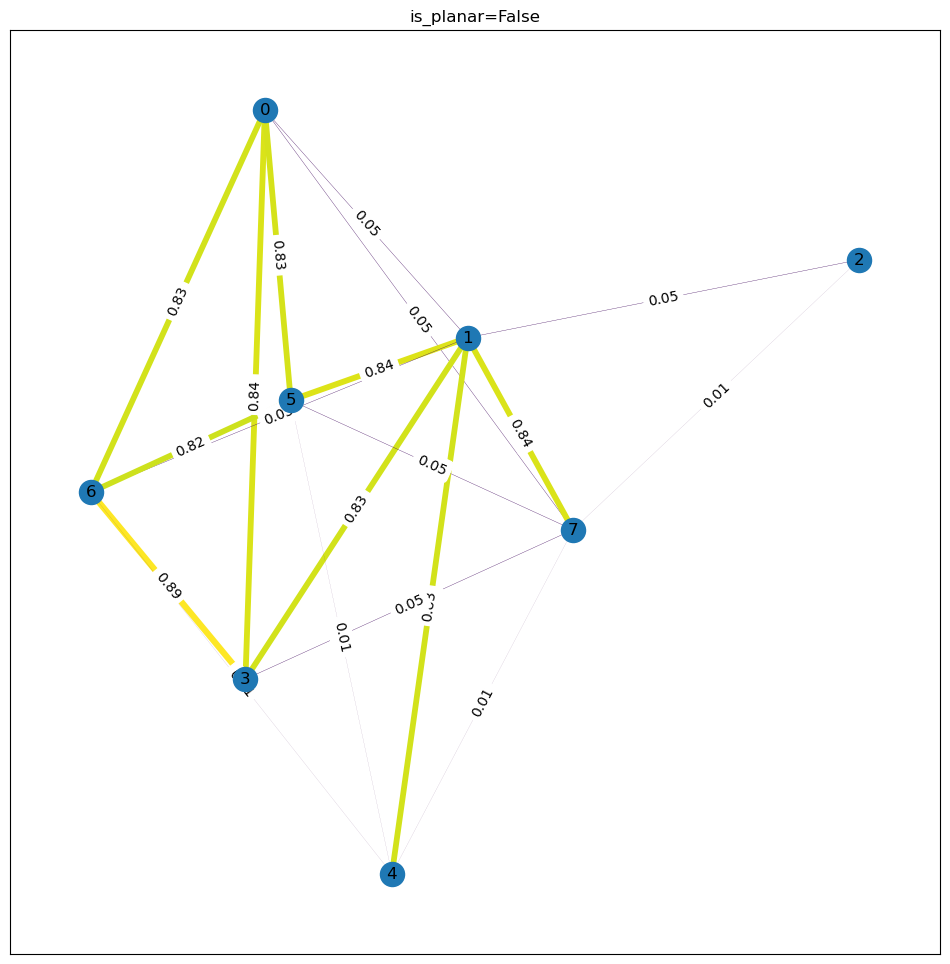

tensor([0])
edge mask: tensor([0.2091, 0.1856, 0.2321, 0.8770, 0.2024, 0.2442, 0.2280, 0.8608, 0.2321,
        0.2258, 0.1429, 0.8409, 0.8463, 0.1828, 0.8407, 0.8399, 0.2482, 0.8323,
        0.2316, 0.1753, 0.2189, 0.2517, 0.8317, 0.8303, 0.8278, 0.2192, 0.1470,
        0.8330, 0.2084, 0.1334, 0.2326, 0.8492, 0.1947, 0.1642, 0.2526, 0.8295,
        0.2284, 0.2165, 0.2140, 0.1373, 0.2263, 0.2488, 0.1507, 0.1980, 0.1724,
        0.1804, 0.1591, 0.2399, 0.1539, 0.2037, 0.2431, 0.8327])
edge adjm: tensor([0.0500, 0.0500, 0.0500, 0.8770, 0.0500, 0.0500, 0.0500, 0.8608, 0.0500,
        0.0500, 0.0500, 0.8409, 0.8463, 0.0500, 0.8407, 0.8399, 0.0500, 0.8323,
        0.0500, 0.0500, 0.0500, 0.0500, 0.8317, 0.0500, 0.0500, 0.0500, 0.0500,
        0.8330, 0.0500, 0.0500, 0.0500, 0.8492, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.8327])


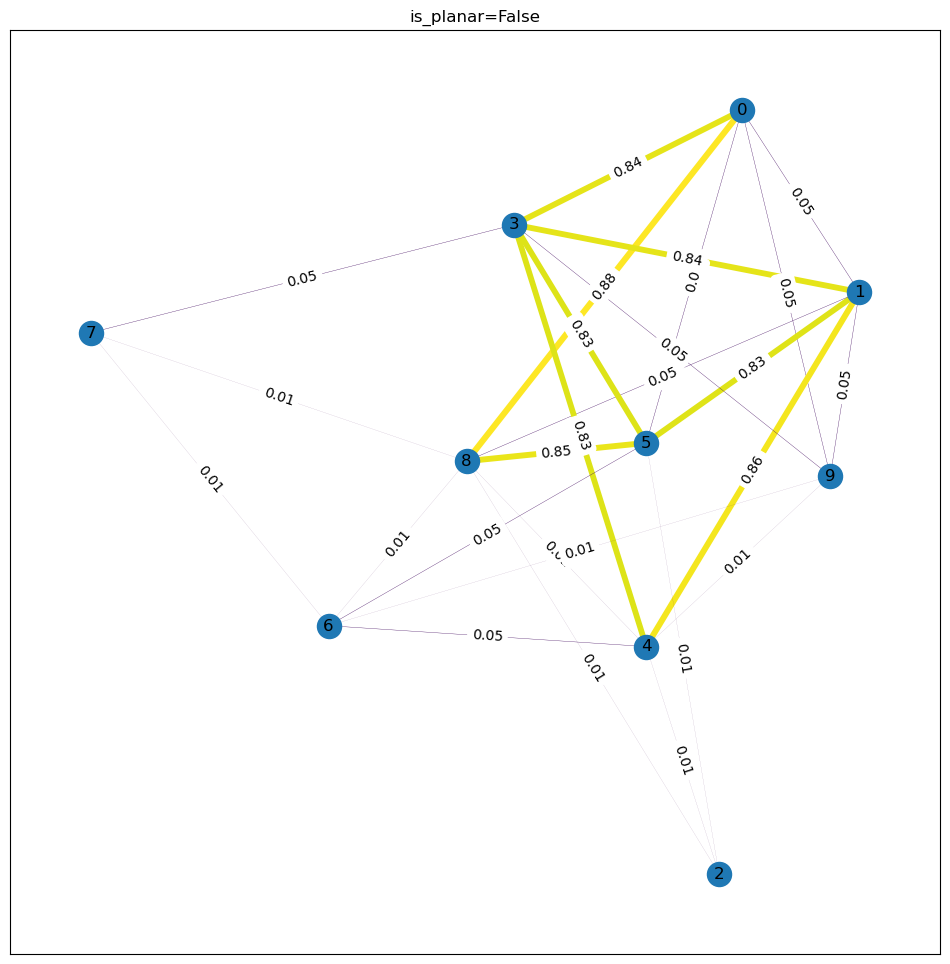

tensor([0])
edge mask: tensor([0.1969, 0.2275, 0.1891, 0.2296, 0.8340, 0.8335, 0.2493, 0.8631, 0.0965,
        0.8702, 0.2334, 0.1115, 0.8437, 0.2417, 0.2428, 0.2447, 0.8337, 0.2237,
        0.2101, 0.2356, 0.2501, 0.2249, 0.2048, 0.1848, 0.8369, 0.1781, 0.2410,
        0.8450, 0.2343, 0.1684, 0.1424, 0.1999, 0.2263, 0.1836, 0.2368, 0.1278,
        0.1459, 0.2536, 0.1791, 0.9176, 0.8293, 0.1222, 0.8586, 0.2044, 0.2417,
        0.1713, 0.2464, 0.2103, 0.2061, 0.2001, 0.8343, 0.8322])
edge adjm: tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.8340, 0.8335, 0.0500, 0.8631, 0.0500,
        0.8702, 0.0500, 0.0500, 0.8437, 0.0500, 0.0500, 0.0500, 0.8337, 0.0500,
        0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.8369, 0.0500, 0.0500,
        0.8450, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.9176, 0.0500, 0.0500, 0.8586, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.8343, 0.0500])


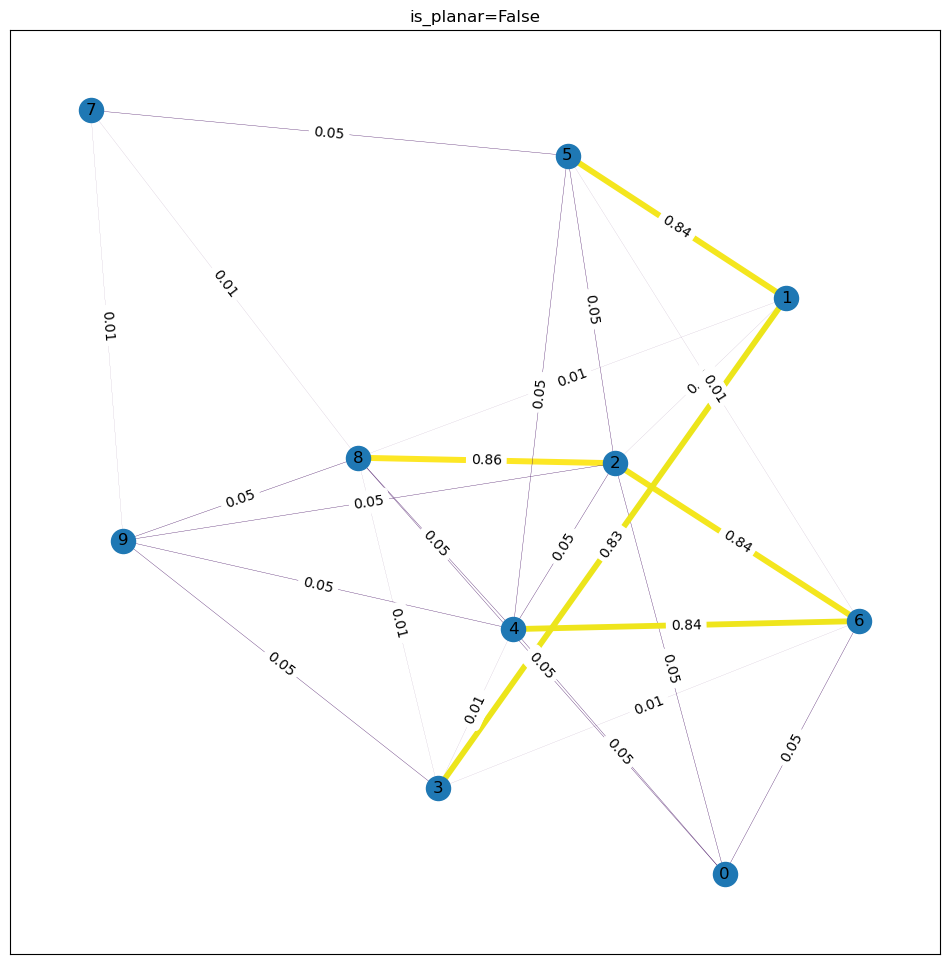

tensor([1])
edge mask: tensor([0.8745, 0.7376, 0.4709, 0.6534, 0.6543, 0.7226, 0.6470, 0.8108, 0.7927,
        0.5497, 0.6444, 0.5015, 0.7121, 0.8939, 0.6742, 0.7612])
edge adjm: tensor([0.8745, 0.7376, 0.0500, 0.6534, 0.6543, 0.7226, 0.0500, 0.8108, 0.7927,
        0.0500, 0.0500, 0.0500, 0.7121, 0.8939, 0.6742, 0.7612])


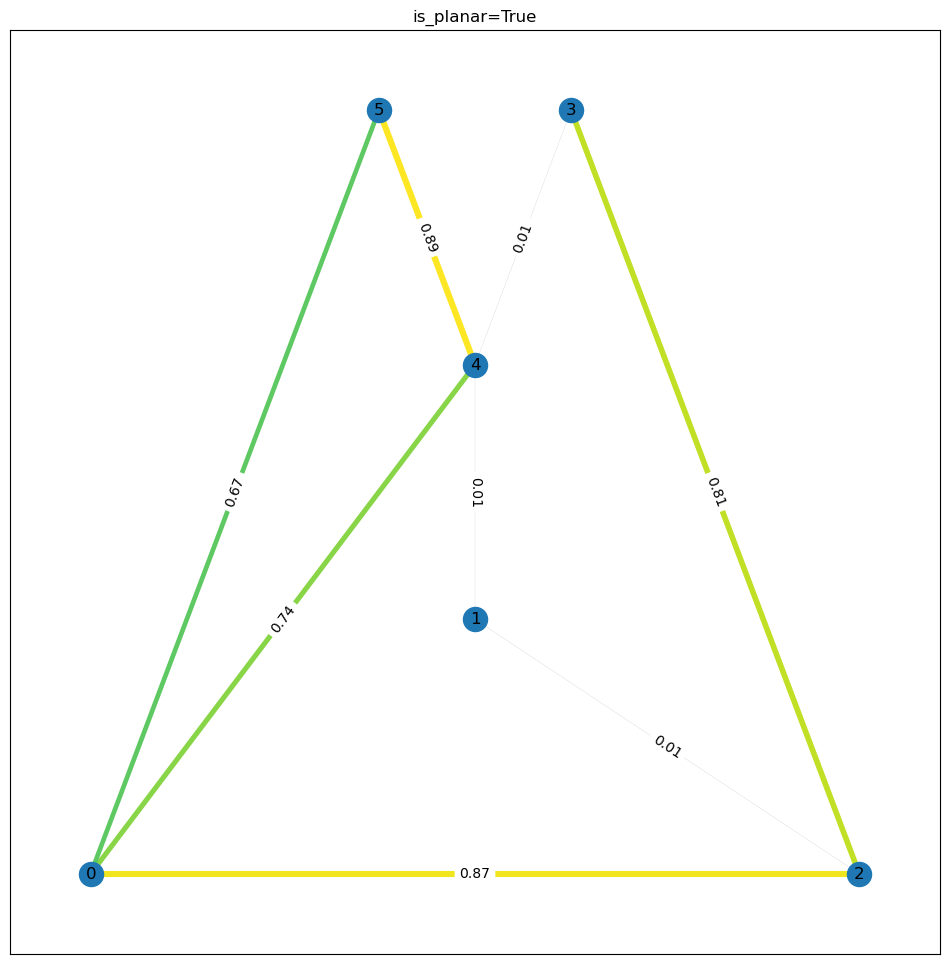

tensor([0])
edge mask: tensor([0.2158, 0.8776, 0.2032, 0.8384, 0.2247, 0.2377, 0.8369, 0.2370, 0.2155,
        0.1713, 0.2104, 0.1952, 0.2268, 0.2032, 0.1945, 0.1184, 0.1976, 0.2336,
        0.8353, 0.8227, 0.1812, 0.2160, 0.8622, 0.1862, 0.1870, 0.2093, 0.2149,
        0.8312, 0.8333, 0.8461, 0.2016, 0.1854, 0.2008, 0.8955, 0.2234, 0.8903,
        0.8726, 0.8196, 0.2392, 0.2274])
edge adjm: tensor([0.0500, 0.8776, 0.0500, 0.8384, 0.0500, 0.0500, 0.8369, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.8353, 0.0500, 0.0500, 0.0500, 0.8622, 0.0500, 0.0500, 0.0500, 0.0500,
        0.8312, 0.8333, 0.8461, 0.0500, 0.0500, 0.0500, 0.8955, 0.0500, 0.8903,
        0.8726, 0.0500, 0.0500, 0.0500])


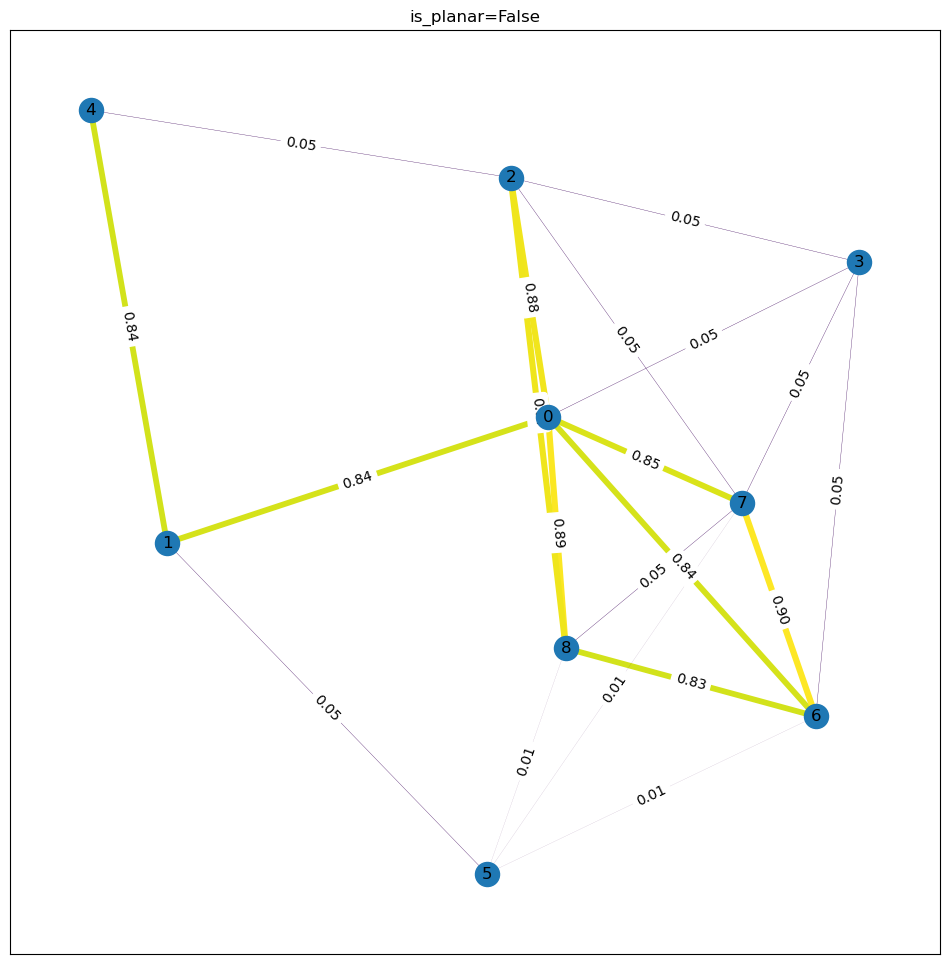

tensor([0])
edge mask: tensor([0.8545, 0.2216, 0.1986, 0.8313, 0.1313, 0.8367, 0.1800, 0.1601, 0.2540,
        0.1964, 0.8482, 0.1587, 0.8318, 0.2222, 0.8452, 0.8391, 0.1987, 0.2486,
        0.8373, 0.2109, 0.1942, 0.2212, 0.8380, 0.8435, 0.2496, 0.2046, 0.2534,
        0.8753, 0.2399, 0.2430, 0.2331, 0.2466, 0.1500, 0.2313, 0.2483, 0.2290,
        0.1638, 0.1755, 0.8341, 0.2178, 0.1735, 0.1911, 0.1897, 0.2021, 0.8319,
        0.2196, 0.2082, 0.1821, 0.8319, 0.8324, 0.2397, 0.8516, 0.2118, 0.1156])
edge adjm: tensor([0.8545, 0.0500, 0.0500, 0.0500, 0.0500, 0.8367, 0.0500, 0.0500, 0.0500,
        0.0500, 0.8482, 0.0500, 0.0500, 0.0500, 0.8452, 0.8391, 0.0500, 0.0500,
        0.8373, 0.0500, 0.0500, 0.0500, 0.8380, 0.8435, 0.0500, 0.0500, 0.0500,
        0.8753, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500, 0.8341, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.8516, 0.0500, 0.0500])


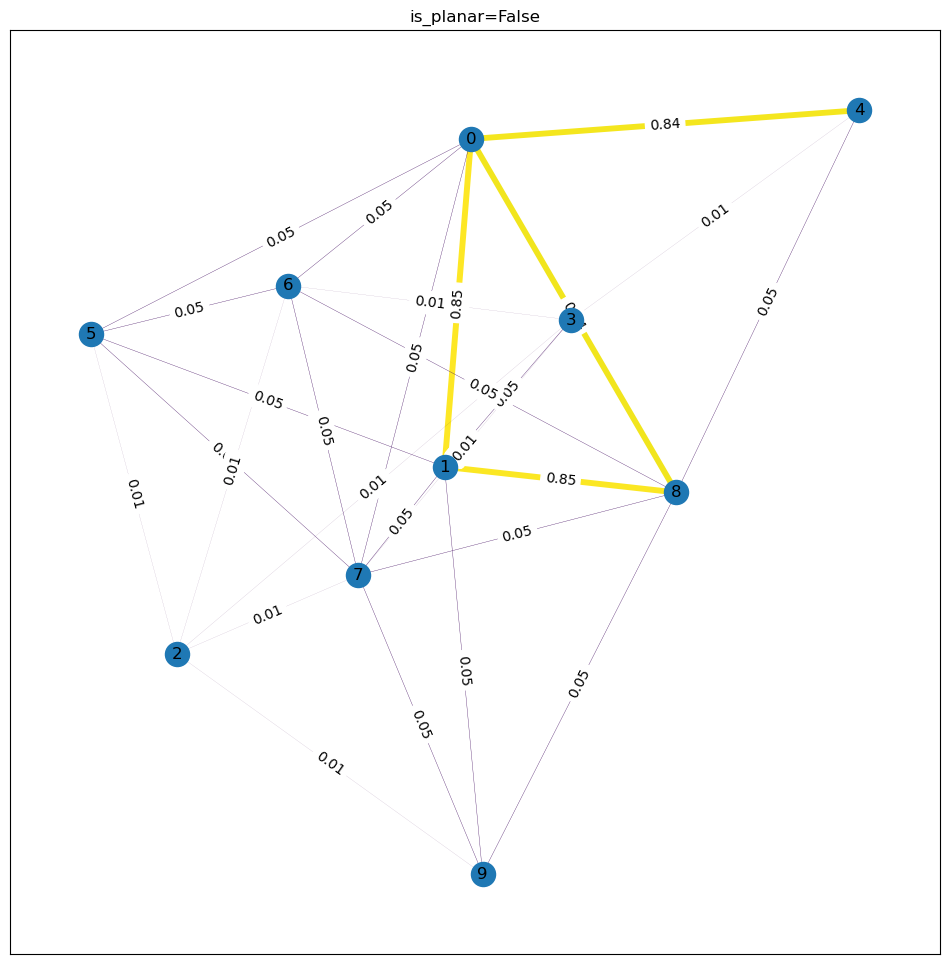

tensor([0])
edge mask: tensor([0.8362, 0.1341, 0.2386, 0.1447, 0.2294, 0.1791, 0.8329, 0.2446, 0.8361,
        0.2046, 0.8362, 0.8511, 0.2492, 0.8478, 0.1514, 0.1759, 0.1761, 0.8436,
        0.1903, 0.1885, 0.8476, 0.2201, 0.8351, 0.2206, 0.1840, 0.1749, 0.8327,
        0.1611, 0.1679, 0.1391, 0.8309, 0.2361, 0.1832, 0.2385, 0.1538, 0.2093,
        0.8325, 0.2096, 0.2138, 0.1787, 0.1058, 0.8362, 0.8326, 0.2466, 0.1960,
        0.8567, 0.1950, 0.1771])
edge adjm: tensor([0.8362, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.8329, 0.0500, 0.8361,
        0.0500, 0.8362, 0.8511, 0.0500, 0.8478, 0.0500, 0.0500, 0.0500, 0.8436,
        0.0500, 0.0500, 0.8476, 0.0500, 0.8351, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.8362, 0.0500, 0.0500, 0.0500,
        0.8567, 0.0500, 0.0500])


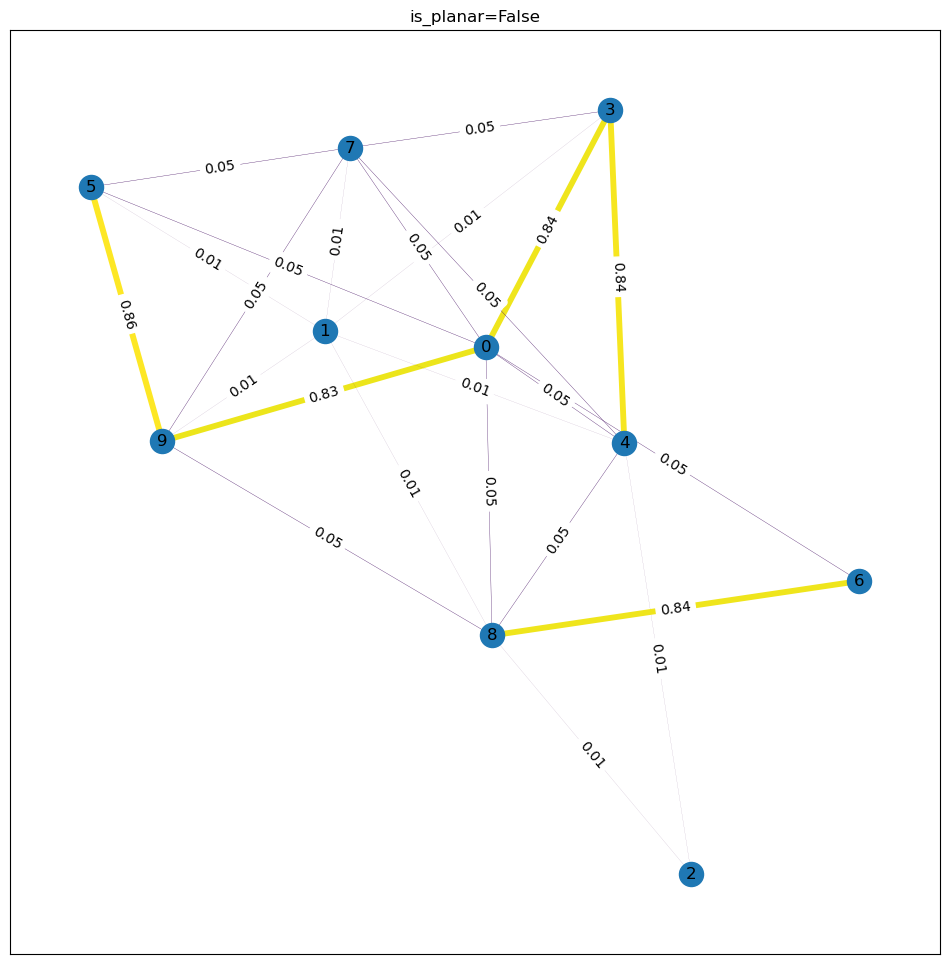

tensor([0])
edge mask: tensor([0.2323, 0.1637, 0.2192, 0.1994, 0.1998, 0.2274, 0.2138, 0.2073, 0.8528,
        0.8590, 0.2229, 0.8338, 0.2277, 0.2331, 0.1308, 0.1844, 0.8623, 0.2246,
        0.8269, 0.8278, 0.8402, 0.8523, 0.1920, 0.1846, 0.2344, 0.2147, 0.2129,
        0.1032, 0.2065, 0.1666, 0.8765, 0.2045, 0.2102, 0.8274])
edge adjm: tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.8528,
        0.8590, 0.0500, 0.8338, 0.0500, 0.0500, 0.0500, 0.0500, 0.8623, 0.0500,
        0.8269, 0.8278, 0.8402, 0.8523, 0.0500, 0.0500, 0.2344, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.8765, 0.0500, 0.0500, 0.8274])


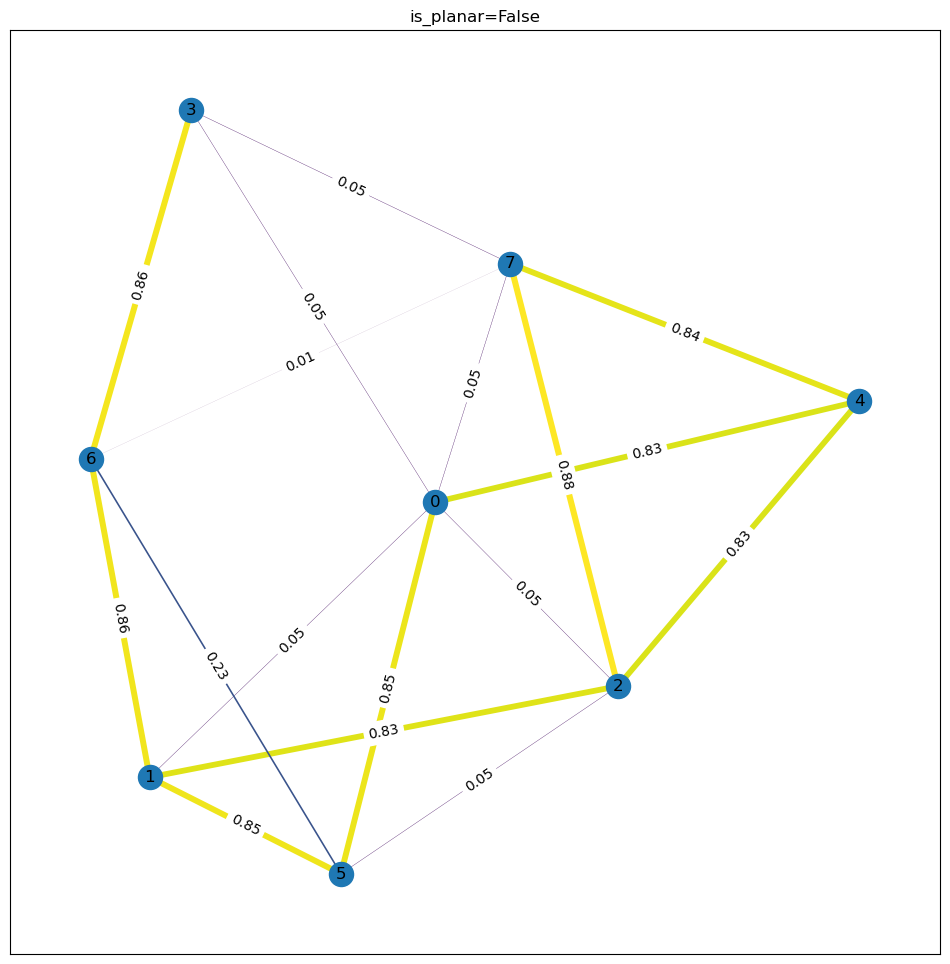

tensor([0])
edge mask: tensor([])


IndexError: kthvalue(): Expected reduction dim 0 to have non-zero size.

In [138]:
def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(lambda: 0.01)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] = max(edge_mask_dict[(u, v)], float(val))
    return edge_mask_dict

for test1 in onehot_8_test_loader_single.dataset[:20]:
    print(test1.y)
    explanation = explainer(x=test1.x, edge_index=test1.edge_index, batch=torch.tensor([0]))
    #explanation.visualize_graph()
    expl = explanation.get_explanation_subgraph()
    #print('node mask:', expl.node_mask)
    print('edge mask:', expl.edge_mask)
    top_mask = torch.kthvalue(expl.edge_mask, expl.edge_mask.shape[0] - 10)
    adjusted_mask = expl.edge_mask.clone().detach()
    adjusted_mask[adjusted_mask <top_mask.values] = 0.05
    print('edge adjm:', adjusted_mask)
    
    edge_mask_dict = aggregate_edge_directions(adjusted_mask, test1)
    #print(test1.edge_index)
    #print(edge_mask_dict)
    plt.figure(figsize=(12,12))
    visualize(test1, edge_mask_dict, color_alpha=5)
    plt.show()
    


## Explain using IG and Saliency from captum

In [8]:
# load the model
conv_model = ConvGNN(hidden_channels=11, num_node_features=ds_onehot_8.num_node_features,
                     num_classes=2)
conv_model = conv_model.to(device)

conv_model.load_state_dict(torch.load("./conv_8_one_hot_100epoch.pickle"))

print(conv_model)

ConvGNN(
  (conv1): GraphConv(11, 11)
  (conv2): GraphConv(11, 11)
  (conv3): GraphConv(11, 11)
  (lin): Linear(in_features=11, out_features=2, bias=True)
)


In [14]:
# this code is copied from PyG tutotial #6 (GNN Explanation) https://colab.research.google.com/drive/1fLJbFPz0yMCQg81DdCP5I8jXw9LoggKO?usp=sharing#scrollTo=Z1mJVbKorh5y
# and adopted to simple graphs afterwards

from captum.attr import Saliency, IntegratedGradients

def explain(model_forward, method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask,
                            target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask,
                                  target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = mask.cpu().detach().numpy()
    return edge_mask


import random
from collections import defaultdict

def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict

ig


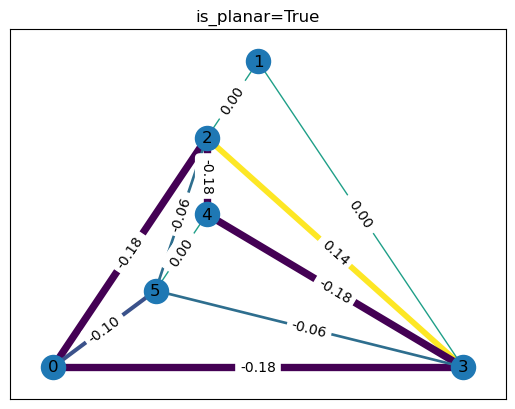

target index = 1
sample_prediction   = tensor([1.2215e-05], grad_fn=<SliceBackward0>)
sum_attributions    = -1.0094633440527003
baseline_prediction = tensor([1.], grad_fn=<SliceBackward0>)
ig


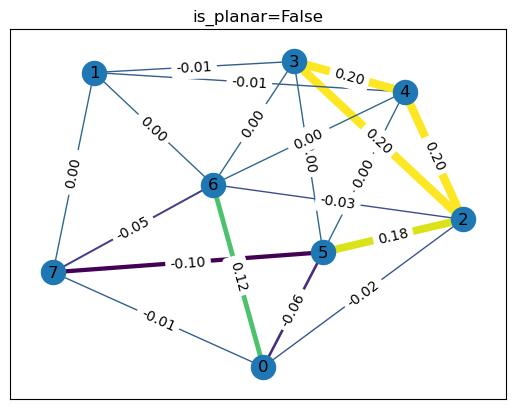

target index = 0
sample_prediction   = tensor([1.], grad_fn=<SliceBackward0>)
sum_attributions    = 1.027987068692618
baseline_prediction = tensor([0.0003], grad_fn=<SliceBackward0>)
ig


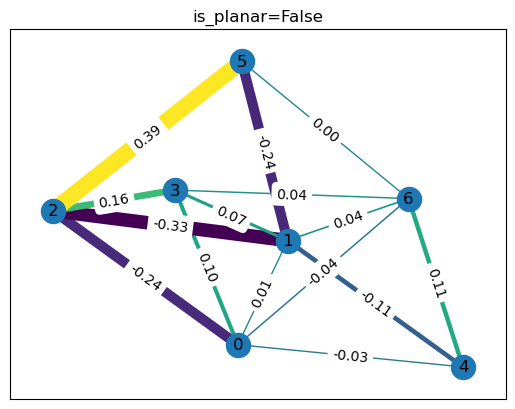

target index = 0
sample_prediction   = tensor([0.9789], grad_fn=<SliceBackward0>)
sum_attributions    = -0.014509567301961693
baseline_prediction = tensor([1.0000], grad_fn=<SliceBackward0>)
ig


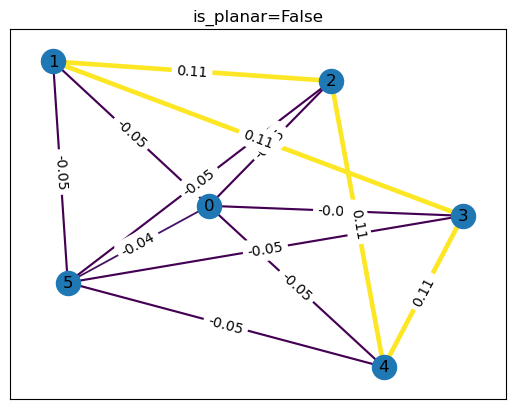

target index = 0
sample_prediction   = tensor([0.9854], grad_fn=<SliceBackward0>)
sum_attributions    = -0.008859819755255419
baseline_prediction = tensor([0.9998], grad_fn=<SliceBackward0>)
ig


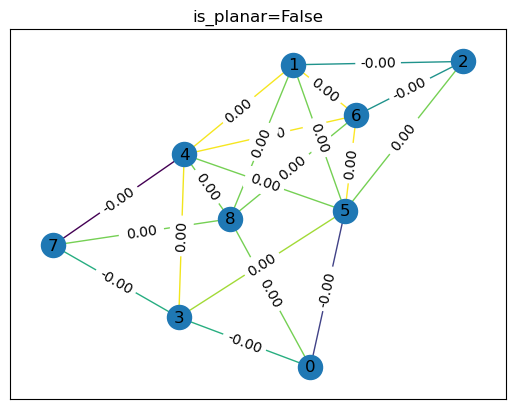

target index = 0
sample_prediction   = tensor([0.9995], grad_fn=<SliceBackward0>)
sum_attributions    = -0.0004433995639369835
baseline_prediction = tensor([1.0000], grad_fn=<SliceBackward0>)
ig


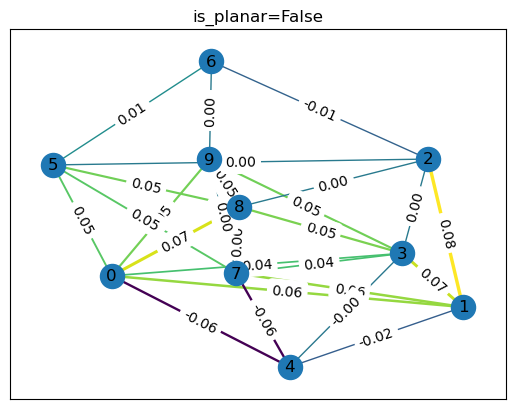

target index = 0
sample_prediction   = tensor([1.], grad_fn=<SliceBackward0>)
sum_attributions    = 0.9879277310688542
baseline_prediction = tensor([8.4081e-07], grad_fn=<SliceBackward0>)
ig


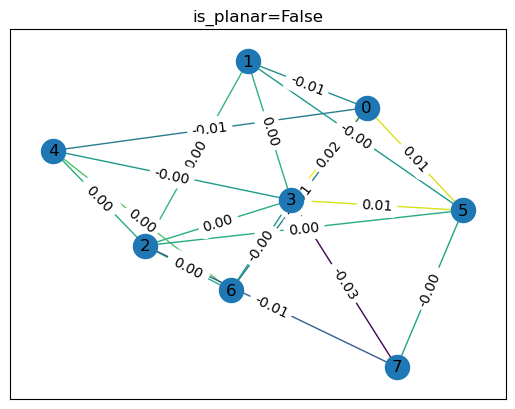

target index = 0
sample_prediction   = tensor([1.0000], grad_fn=<SliceBackward0>)
sum_attributions    = 0.023097675164147593
baseline_prediction = tensor([0.9870], grad_fn=<SliceBackward0>)
ig


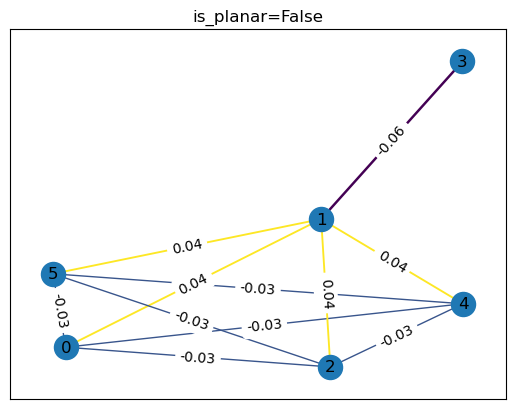

target index = 0
sample_prediction   = tensor([0.9313], grad_fn=<SliceBackward0>)
sum_attributions    = -0.0701997053755398
baseline_prediction = tensor([1.0000], grad_fn=<SliceBackward0>)
ig


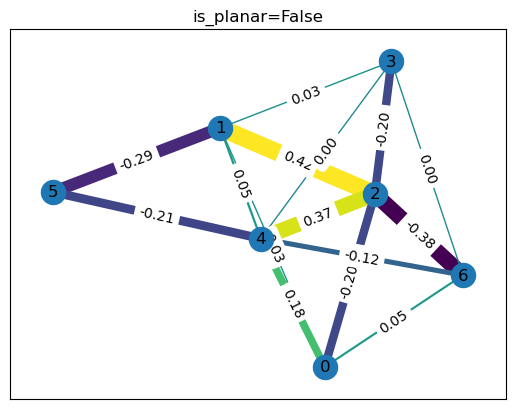

target index = 0
sample_prediction   = tensor([0.9980], grad_fn=<SliceBackward0>)
sum_attributions    = -0.020234145349939336
baseline_prediction = tensor([0.9808], grad_fn=<SliceBackward0>)
ig


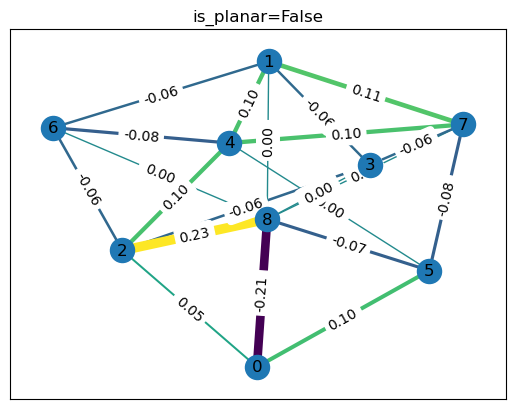

target index = 0
sample_prediction   = tensor([1.], grad_fn=<SliceBackward0>)
sum_attributions    = 0.31487109970937693
baseline_prediction = tensor([0.7907], grad_fn=<SliceBackward0>)


In [44]:
def conv_model_forward(edge_mask, data):
    conv_model.eval()
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = conv_model(data.x, data.edge_index, batch, edge_mask)
    softmax_layer = torch.nn.Softmax(dim=1)
    softmax_out = softmax_layer(out)
    #print(f"out={out}")
    #print(f"softmax={softmax_out}")
    is_not_planar = softmax_out[0][0:1]
    return is_not_planar

samples = onehot_8_test_loader.dataset[:10]

for data in samples:
    for title, method in [('Integrated Gradients', 'ig')]:#, ('Saliency', 'saliency')]:
        sample_mask = torch.ones(data.edge_index.shape[1]).to(device)
        zero_mask = torch.zeros(data.edge_index.shape[1]).to(device)
        sample_prediction = conv_model_forward(sample_mask, data)
        baseline_prediction = conv_model_forward(zero_mask, data)
        
        edge_mask = explain(conv_model_forward, method, data, target=None)
        edge_mask_dict = aggregate_edge_directions(edge_mask, data)
        print(method)
        sum_attributions = sum(edge_mask)
        visualize(data, edge_mask_dict)
        plt.show()

        print(f"target index = {data.y[0]}")
        print(f"sample_prediction   = {sample_prediction}")
        print(f"sum_attributions    = {sum_attributions}")
        print(f"baseline_prediction = {baseline_prediction}")
        #print(edge_mask)
        #plt.figure(figsize=(10, 5))
        #plt.title(title)
